<a href="https://colab.research.google.com/github/Ines8991/classification_rna/blob/main/Mod%C3%A8le_universit%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression

##CHARGEMENT ET TRAITEMENT DE VALEURS MANQUANTES POTENTIELLES

Il faudrait charger le fichier data_licence1 (2) recensant les caractéristiques des étudiants sur 2 ans, le fichier distance_et_nom_commune permettant de calculer la distance et le nouveau finchier dont on veut prédire les RNA

In [2]:
don=pd.read_excel(r'/content/data_licence1 (2).xlsx')
don.shape

(21758, 70)

Traitement de potentielles valeurs manquantes dans le nouveau fichier

In [3]:
new=pd.read_excel(r'/content/data_licence_2021.xlsx')
new.columns.tolist()

['Année_N',
 'Individu - Code Etudiant',
 'Individu - Sexe',
 'Nationalité (code)',
 'Age au bac',
 'Groupe de bac',
 'Série du bac',
 'Bac - Mention (lib.)',
 'IPS du lycée',
 'Etudiant oui ou oui-si',
 'PCS - parent (lib.)_Année_N',
 'Profession du parent 2_Année_N',
 'Situation année précédente (lib.)_Année_N',
 'Diplôme Evry ou Saclay_Année_N+1',
 'IAE - Etape (lib.)_Année_N',
 'Diplôme SISE intitulé 1 (lib.)_Année_N',
 'Discipline SISE (lib.)_Année_N',
 'Secteur disciplinaire SISE (lib.)_Année_N',
 'Composante_Année_N',
 'Nombre d’admis VET_Année_N',
 'Adresse fixe - Commune (code)_Année_N',
 'Adresse fixe - Commune (code)_Année_N+1',
 'IAE - Etape (lib.)_Année_N+1',
 'Boursier (O/N)_Année_N',
 'Note Session 1_Année_N',
 'Résultat Session 1_Année_N',
 'Note Session 2_Année_N',
 'Résultat Session 2_Année_N',
 'PCS - parent (lib.)_Année_N+1',
 "Type d'étape_Année_N+1",
 'Profession du parent 2_Année_N+1',
 "Régime d'inscription (lib.)_Année_N+1",
 'Boursier (O/N)_Année_N+1',
 'RNA']

In [4]:
dist=pd.read_excel(r'/content/distance_et_nom_commune.xlsx')

In [5]:
new['Adresse fixe - Commune (code)_Année_N']=new['Adresse fixe - Commune (code)_Année_N'].astype(int)
new['Adresse fixe - Commune (code)_Année_N'] = new['Adresse fixe - Commune (code)_Année_N'].astype(str)
new['Adresse fixe - Commune (code)_Année_N'] = new['Adresse fixe - Commune (code)_Année_N'].apply(lambda x: f'{x}')

In [6]:
new['Adresse fixe - Commune (code)_Année_N+1']=new['Adresse fixe - Commune (code)_Année_N+1'].astype(int)
new['Adresse fixe - Commune (code)_Année_N+1'] = new['Adresse fixe - Commune (code)_Année_N+1'].astype(str)
new['Adresse fixe - Commune (code)_Année_N+1'] = new['Adresse fixe - Commune (code)_Année_N+1'].apply(lambda x: f'{x}')

In [7]:
new=pd.merge(new,dist,left_on="Adresse fixe - Commune (code)_Année_N",right_on="Adresse fixe - Commune (code)",how="left")
new.head(2)



,Année_N,Individu - Code Etudiant,Individu - Sexe,Nationalité (code),Age au bac,Groupe de bac,Série du bac,Bac - Mention (lib.),IPS du lycée,Etudiant oui ou oui-si,...,Résultat Session 2_Année_N,PCS - parent (lib.)_Année_N+1,Type d'étape_Année_N+1,Profession du parent 2_Année_N+1,Régime d'inscription (lib.)_Année_N+1,Boursier (O/N)_Année_N+1,RNA,Adresse fixe - Commune (code),nom_de_la_commune,Distance_en_km
0,2021,20032780,F,100,20,Bac techno,STMG,Passable,0.0,Oui,...,Admis,"chômeur, sans activité professionnelle",L2,sans objet ou non renseigné,FC sans CP,N,NonRNA,91286,GRIGNY,4.595448
1,2021,20151426,M,100,20,Bac pro,Bac Pro Tertiaire,Bien,88.3,Oui,...,Admis,professions intermédiaires,L2,"chômeur, sans activité professionnelle",FC sans CP,N,NonRNA,91432,MORANGIS,10.861572


In [8]:
del new['Adresse fixe - Commune (code)_Année_N']
del new['nom_de_la_commune']
new.rename(columns={'Distance_en_km': 'Distance_en_km_Année_N'}, inplace=True)

In [9]:

new=pd.merge(new,dist,left_on="Adresse fixe - Commune (code)_Année_N+1",right_on="Adresse fixe - Commune (code)",how="left")
del new['Adresse fixe - Commune (code)_Année_N+1']
del new['nom_de_la_commune']
new.rename(columns={'Distance_en_km': 'Distance_en_km_Année_N+1'}, inplace=True)

In [10]:
new['Distance_en_km_Année_N'].fillna(new['Distance_en_km_Année_N'].mean(),inplace=True)
new['Distance_en_km_Année_N+1'].fillna(new['Distance_en_km_Année_N+1'].mean(),inplace=True)

In [11]:
new['Age au bac'].fillna(0,inplace=True)
new['Bac - Mention (lib.)'].fillna("Sans mention",inplace=True)
new['RNA'].fillna("NonRNA",inplace=True)
new['IPS du lycée'].fillna(0,inplace=True)
new['Profession du parent 2_Année_N'].fillna("NonRenseigné",inplace=True)
new['PCS - parent (lib.)_Année_N'].fillna("NonRenseigné",inplace=True)

In [12]:
for i in range(len(new)):
  if (new['Note Session 1_Année_N'][i]<10) & (new['Note Session 1_Année_N'][i]>=0) and pd.isnull(new['Résultat Session 1_Année_N'][i]) :
    new['Résultat Session 1_Année_N'][i]="Ajourné"
  if (new['Note Session 2_Année_N'][i]<10) & (new['Note Session 2_Année_N'][i]>=0 and pd.isnull(new['Résultat Session 2_Année_N'][i])):
    new['Résultat Session 2_Année_N'][i]="Ajourné"
  if (new['Note Session 1_Année_N'][i]>=10 and pd.isnull(new['Résultat Session 1_Année_N'][i])):
    new['Résultat Session 1_Année_N'][i]="Admis"
  if (new['Note Session 2_Année_N'][i]>=10 and pd.isnull(new['Résultat Session 2_Année_N'][i])):
    new['Résultat Session 2_Année_N'][i]="Admis"

In [13]:
for i in range(len(new)):
  if (new['Note Session 1_Année_N'][i]<10) & (new['Note Session 1_Année_N'][i]>=0) and pd.isnull(new['Résultat Session 1_Année_N'][i]) :
    new['Résultat Session 1_Année_N'][i]="Ajourné"
  if (new['Note Session 2_Année_N'][i]<10) & (new['Note Session 2_Année_N'][i]>=0 and pd.isnull(new['Résultat Session 2_Année_N'][i])):
    new['Résultat Session 2_Année_N'][i]="Ajourné"
  if (new['Note Session 1_Année_N'][i]>=10 and pd.isnull(new['Résultat Session 1_Année_N'][i])):
    new['Résultat Session 1_Année_N'][i]="Admis"
  if (new['Note Session 2_Année_N'][i]>=10 and pd.isnull(new['Résultat Session 2_Année_N'][i])):
    new['Résultat Session 2_Année_N'][i]="Admis"

In [14]:
for i in range(len(new)):
  if new['Note Session 1_Année_N'][i]<10 and pd.isnull(new['Note Session 2_Année_N'][i]):
    new['Note Session 2_Année_N'][i]=new['Note Session 1_Année_N'][i]
  if new['Note Session 2_Année_N'][i]<10 and pd.isnull(new['Résultat Session 2_Année_N'][i]):
    new['Résultat Session 2_Année_N'][i]=new['Résultat Session 1_Année_N'][i]

In [15]:
new['Note Session 1_Année_N'].fillna(-1,inplace=True)
new['Note Session 2_Année_N'].fillna(-1,inplace=True)
new['Discipline SISE (lib.)_Année_N'].fillna("SFA",inplace=True)
new['Secteur disciplinaire SISE (lib.)_Année_N'].fillna("Mathématiq",inplace=True)

In [17]:
don = don[don['Année_N'] != 2019]


In [18]:
don['Année_N'].unique()

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2020, 2021])

In [19]:
df=don[don['Nombre d’admis VET_Année_N']==0]
df=df[df["Type d\'étape_Année_N+1"]=="L1"]
data=df[df['IAE - Etape (lib.)_Année_N']==df['IAE - Etape (lib.)_Année_N+1']]
data.shape
data = data.reset_index(drop=True)

In [20]:
new=new[new['Nombre d’admis VET_Année_N']==0]
new=new[new["Type d\'étape_Année_N+1"]=="L1"]
new=new[new['IAE - Etape (lib.)_Année_N']==new['IAE - Etape (lib.)_Année_N+1']]
new = new.reset_index(drop=True)

In [21]:
new.shape

(499, 36)

In [22]:
new.shape
newnew=new.copy()

In [23]:
del new['Nombre d’admis VET_Année_N']
del new["Type d\'étape_Année_N+1"]
del new['IAE - Etape (lib.)_Année_N+1']
del new['Adresse fixe - Commune (code)_x']
del new['Adresse fixe - Commune (code)_y']

In [24]:
column_names = new.columns
data = data[column_names]
data.shape

(4202, 31)

In [25]:
new.columns

Index(['Année_N', 'Individu - Code Etudiant', 'Individu - Sexe',
       'Nationalité (code)', 'Age au bac', 'Groupe de bac', 'Série du bac',
       'Bac - Mention (lib.)', 'IPS du lycée', 'Etudiant oui ou oui-si',
       'PCS - parent (lib.)_Année_N', 'Profession du parent 2_Année_N',
       'Situation année précédente (lib.)_Année_N',
       'Diplôme Evry ou Saclay_Année_N+1', 'IAE - Etape (lib.)_Année_N',
       'Diplôme SISE intitulé 1 (lib.)_Année_N',
       'Discipline SISE (lib.)_Année_N',
       'Secteur disciplinaire SISE (lib.)_Année_N', 'Composante_Année_N',
       'Boursier (O/N)_Année_N', 'Note Session 1_Année_N',
       'Résultat Session 1_Année_N', 'Note Session 2_Année_N',
       'Résultat Session 2_Année_N', 'PCS - parent (lib.)_Année_N+1',
       'Profession du parent 2_Année_N+1',
       'Régime d'inscription (lib.)_Année_N+1', 'Boursier (O/N)_Année_N+1',
       'RNA', 'Distance_en_km_Année_N', 'Distance_en_km_Année_N+1'],
      dtype='object')

In [26]:
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

print('Avant codage:')
print(pd.value_counts(data["RNA"]))
data["RNA"] = coding(data["RNA"], {'NonRNA':0.0,'RNA':1.0})
print('\nAprès codage:')
print(pd.value_counts(data["RNA"]))

Avant codage:
RNA       2833
NonRNA    1369
Name: RNA, dtype: int64

Après codage:
1.0    2833
0.0    1369
Name: RNA, dtype: int64


In [27]:
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

print('Avant codage:')
print(pd.value_counts(new["RNA"]))
new["RNA"] = coding(new["RNA"], {'NonRNA':0.0,'RNA':1.0})
print('\nAprès codage:')
print(pd.value_counts(new["RNA"]))

Avant codage:
RNA       493
NonRNA      6
Name: RNA, dtype: int64

Après codage:
1.0    493
0.0      6
Name: RNA, dtype: int64


In [28]:
combined_data = pd.concat([data, new], ignore_index=True)
dat_columns = combined_data.select_dtypes(['object']).columns

for col in dat_columns:
    combined_data[col] = pd.factorize(combined_data[col])[0]

data_len = len(data)
new_len = len(new)

data_factorized = combined_data.iloc[:data_len]
new_factorized = combined_data.iloc[data_len:]

In [29]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data_factorized)
new_scaled = scaler.transform(new_factorized)
scaled_data_df = pd.DataFrame(scaled_data, columns=column_names)
new_scaled_df = pd.DataFrame(new_scaled, columns=column_names)


In [30]:
data=scaled_data_df.copy()
new=new_scaled_df.copy()
data=data[data['Année_N']!=data['Année_N'].max()]
data=data.reset_index(drop=True)
del data['Individu - Code Etudiant']
del data['Année_N']
del new['Individu - Code Etudiant']
del new['Année_N']

In [31]:
new['RNA'].value_counts()

 0.0    493
-1.0      6
Name: RNA, dtype: int64

In [32]:
data['RNA'] = data['RNA'].replace({0.0: 1, -1.0: 0})
new['RNA'] = new['RNA'].replace({0.0: 1, -1.0: 0})

In [33]:
X=data.drop(columns='RNA')
y=data[['RNA']]
Xnew=new.drop(columns='RNA')


##Entrainement du modèle

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
logreg_model = LogisticRegression(C=1.0, penalty='l2',max_iter=1000,solver='lbfgs',random_state=42)
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(Xnew)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
predictions = logreg_model.predict(Xnew)
predictions_df = pd.DataFrame({'Predictions_RNA': predictions})
newnew['Predictions_RNA']=predictions_df['Predictions_RNA']
predictions_proba = logreg_model.predict_proba(Xnew)
predicted_class_probabilities = 100*predictions_proba[:, 1]
df_predictions = pd.DataFrame(predicted_class_probabilities, columns=['Probabilité_RNA'])

In [36]:
newnew=newnew.reset_index(drop=True)
df2021_with_probabilities = newnew.assign(Probabilité_RNA=df_predictions['Probabilité_RNA'])
df2021_with_probabilities=df2021_with_probabilities.assign(Prediction_RNA_2022=predictions_df['Predictions_RNA'])
df2021_with_probabilities=df2021_with_probabilities.reset_index(drop=True)

In [37]:
for i in range(len(df2021_with_probabilities)):
  if df2021_with_probabilities['Prediction_RNA_2022'][i]==1:
    df2021_with_probabilities['Predictions_RNA'][i]="RNA"
  else:
    df2021_with_probabilities['Predictions_RNA'][i]="NonRNA"

<ipython-input-37-8b2554d58124>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2021_with_probabilities['Predictions_RNA'][i]="RNA"


In [38]:
data2021=df2021_with_probabilities[['Individu - Code Etudiant','Note Session 1_Année_N','Résultat Session 1_Année_N','Note Session 2_Année_N','Résultat Session 2_Année_N','Série du bac','Predictions_RNA','Probabilité_RNA']].copy()

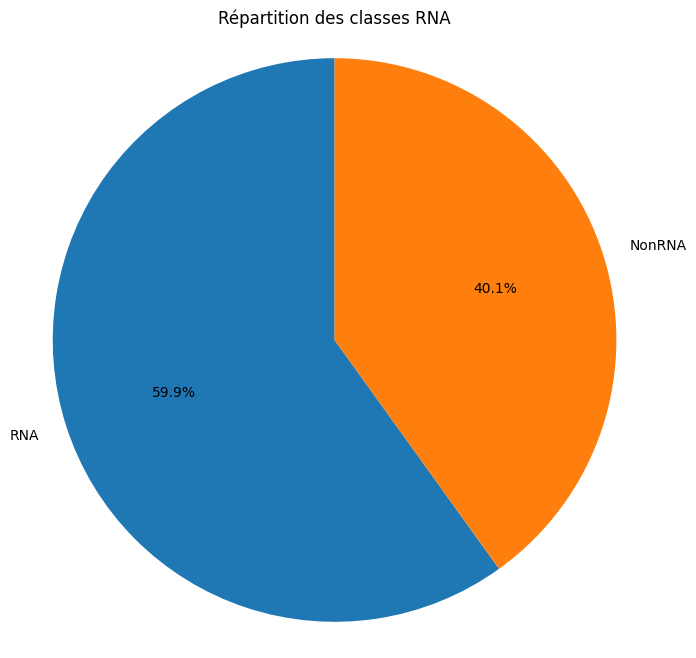

In [39]:
class_counts = data2021['Predictions_RNA'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Répartition des classes RNA')

plt.show()

In [40]:
for i in range(len(data2021)):
  if data2021['Probabilité_RNA'][i]<=25:
    data2021['Probabilité_RNA'][i]="Entre 0 et 25% de chances d'être RNA"
  elif (data2021['Probabilité_RNA'][i]>25) & (data2021['Probabilité_RNA'][i]<=50):
    data2021['Probabilité_RNA'][i]="Entre 25% et 50% de chances d'être RNA"
  elif (data2021['Probabilité_RNA'][i]>50) & (data2021['Probabilité_RNA'][i]<=75):
    data2021['Probabilité_RNA'][i]="Entre 50% et 75% de chances d'être RNA"
  elif data2021['Probabilité_RNA'][i]>75:
    data2021['Probabilité_RNA'][i]="Entre 75% et 100% de chances d'être RNA"


<ipython-input-40-d6beccc6d7bd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2021['Probabilité_RNA'][i]="Entre 50% et 75% de chances d'être RNA"


In [41]:
data2021['Note Session 1_Année_N'] = data2021['Note Session 1_Année_N'].replace(-1, np.nan)
data2021['Note Session 2_Année_N'] = data2021['Note Session 2_Année_N'].replace(-1, np.nan)

In [42]:
file='prediction_licence1.xlsx'
data2021.to_excel(file, index=False)
print("Success")

Success


Le fichier obtenu est prediction_licence1. Il comporte le code étudiant, les notes et résultats en session 1 et 2, la série du bac, la probabilité d'être RNA et la prédiction faite par le modèle